In [1]:
# ! pip install imbalanced-learn
# ! pip install --force-reinstall 'scikit-learn==0.19.2' 
# ! pip install pickle-mixin
# ! pip install --force-reinstall 'scikit-learn==0.19.2' 

In [2]:
import math
import json
import pickle
import numpy as np
import pandas as pd
import coremltools as ct
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

from sklearn.tree import _tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.
TensorFlow version 2.14.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


In [3]:
STAGE = {
    'In Bed': 0,
    'Awake': 1,
    'Asleep': 2,
    'REM': 3,
    'Core': 4,
    'Deep': 5,
    'Unknown': 6
}

In [4]:
def load_json(path: str) -> dict:
    with open(path, 'r') as file:
        return json.load(file)

def parse_time(time: str) -> datetime:
    return datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

def to_min(cur_time: datetime, start_time: datetime) -> int:
    return int((cur_time - start_time).total_seconds()//60)

def process_sleep_data(sleep_data: dict) -> dict:
    stage_data = defaultdict(dict)

    for data in sleep_data:
        if data['stage'] in ['Awake', 'REM', 'Core', 'Deep']:
            start_time = parse_time(data['start_time'])
            end_time = parse_time(data['end_time'])
            date = end_time.strftime('%Y-%m-%d')

            if not date in stage_data: stage_data[date]['stages'] = list()
            stage_data[date]['stages'].append({
                'start_time': start_time,
                'end_time': end_time,
                'stage': STAGE[data['stage']]
            })

    for date, data in stage_data.items():
        stage_data[date]['stages'] = sorted(data['stages'], key=lambda x: x['start_time'])
        stage_data[date]['start_time'] = stage_data[date]['stages'][0]['start_time']
        stage_data[date]['end_time'] = stage_data[date]['stages'][-1]['end_time']
        stage_data[date]['day_of_week'] = stage_data[date]['start_time'].weekday()

    return stage_data

def post_process(stage_data: dict) -> pd.DataFrame:
    ml_data = list()
    for date, data in stage_data.items():
        for item in data['stages']:
            start_time = to_min(item['start_time'], data['start_time'])
            end_time = to_min(item['end_time'], data['start_time'])
            for time in range(start_time, end_time):
                ml_data.append((
                    date,
                    data['day_of_week'],
                    time,
                    item['stage']
                ))
    return pd.DataFrame(ml_data, columns=['date', 'day_of_week', 'time', 'stage'])

In [5]:
data = load_json('./sleepData.json')
data = data['sleep_data']

stage_data = process_sleep_data(data)
ml_data = post_process(stage_data)

print(ml_data['stage'].value_counts())
print(ml_data['day_of_week'].value_counts())
print(max(ml_data['time']))
ml_data

stage
4    109175
3     53845
5     27051
1      4937
Name: count, dtype: int64
day_of_week
1    30793
0    29565
4    29299
2    28885
3    27739
6    26211
5    22516
Name: count, dtype: int64
813


,date,day_of_week,time,stage
0,2024-02-20,1,0,4
1,2024-02-20,1,1,4
2,2024-02-20,1,2,4
3,2024-02-20,1,3,4
4,2024-02-20,1,4,4
...,...,...,...,...
195003,2022-09-13,1,279,4
195004,2022-09-13,1,280,4
195005,2022-09-13,1,281,4
195006,2022-09-13,1,282,4


In [6]:
X = ml_data[['time', 'day_of_week']].values
Y = ml_data['stage'].values
# print(X)
# print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
# print(X_train)
# print(Y_train)

# smote = SMOTE()
# X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train)
# print(X_train_sm)
# print(Y_train_sm)

In [7]:
model = RandomForestClassifier(random_state=42)
# model.fit(X_train_sm, Y_train_sm)
model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Predict on the test set
Y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.582662427567817
Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.00      0.00       988
           3       0.47      0.20      0.28     10769
           4       0.60      0.85      0.70     21835
           5       0.61      0.38      0.47      5410

    accuracy                           0.58     39002
   macro avg       0.48      0.36      0.36     39002
weighted avg       0.55      0.58      0.53     39002



[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4
 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 3 4 3 4 4 3 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4
 4 4 4 3 3 4 3 3 3 3 3 4 4 4 3 3 3 3 3 3 3 3 4 3 3 3 3 4 3 3 3 3 3 3 3 3]
4    383
3     57
5     40

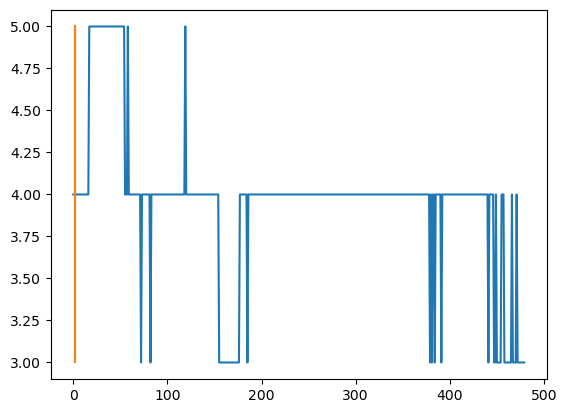

In [9]:
dow = 2
X_sample = [[i, dow] for i in range(8*60)]
Y_sample = model.predict(X_sample)
print(Y_sample)

print(pd.Series(Y_sample).value_counts())
plt.plot(X_sample, Y_sample)

In [10]:
with open('SleepStageRandomForest.pkl', 'wb') as file:
    pickle.dump(model, file)

In [11]:
# Convert the model
coreml_model = ct.converters.sklearn.convert(model, input_features=['time', 'day_of_week'], output_feature_names='sleep_stage')

# Save the model
coreml_model.save("SleepStageRandomForest.mlmodel")
# coreml_model.save("SleepStageRandomForest.mlpackage")

# Loading the model
# with open('my_random_forest_model.pkl', 'rb') as file:
#     best_model_loaded = pickle.load(file)

NameError: name '_tree' is not defined